### Генерация музыки, хорошо подходящей под видеоролик с учетом настроения и выделением ключевых моментов
Поклонская Мария



Тестирование готовых решений по анализу настроения и выделению ключевых моментов в видео

In [ ]:
!git clone https://github.com/fabiocarrara/visual-sentiment-analysis.git

Cloning into 'visual-sentiment-analysis'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 24 (delta 9), reused 13 (delta 3), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [ ]:
%cd /content/visual-sentiment-analysis

/content/visual-sentiment-analysis


In [ ]:
!/content/visual-sentiment-analysis/download_models.sh

Сначала протестируем на наборе изображений (не видео)

In [ ]:
!python predict.py images.txt --model vgg19_finetuned_all --batch-size 64 > predictions.csv

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0% 0/1 [00:00<?, ?it/s]/content/visual-sentiment-analysis/vgg19.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax         = F.softmax(fc8_retrain_1)
100% 1/1 [00:02<00:00,  2.76s/it]


Порядок классов (вероятностей) в выходной табличке:  negative, neutral, and positive

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/visual-sentiment-analysis/predictions.csv', header=None)
df.columns = ['negative', 'neutral', 'positive']
df

,negative,neutral,positive
0,0.123606,0.355793,0.520602
1,0.417036,0.041934,0.541029
2,0.627535,0.199636,0.172829
3,0.365742,0.246392,0.387866
4,0.668253,0.041122,0.290625
5,0.211278,0.212866,0.575857


Теперь возьмем видео, разобьем его покадрово и попробуем проанализировать настроение

In [ ]:
!pip install pytorchvideo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 4.7 MB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 
     |████████████████████████████████| 30.7 MB 1.3 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188714 sha256=7246b2798fcf39a8c1c298c6bbf37ca73fd3e57598c2571109bd1cbdf2f6be07
  Stored in directory: /root/.cache/pip/wheels/e8/51/05/053b29bac2400cbbae2fb7cfc41afd280d627bca7c9363ca80
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=dd90cd4f31be96ea9c21edd01e90afc72215bf30c0a036d6d1f444ebc096cadf
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31549 sha256=236f85d21575f5aba7385c400fb0bbbfe551694255761a5a

In [ ]:
import torch
import json
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)
from typing import Dict
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/_functional_video.py:7: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in 0.14. Please use the 'torchvision.transforms.functional' module instead.
  "The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in 0.14. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/_transforms_video.py:26: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in 0.14. Please use the 'torchvision.transforms' module instead.
  "The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in 0.14. "


In [ ]:
!wget https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4
video_path = "archery.mp4"

# Select the duration of the clip to load by specifying the start and end duration
# The start_sec should correspond to where the action occurs in the video
# start_sec = 0
video = EncodedVideo.from_path(video_path)

--2022-11-06 14:13:05--  https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 549197 (536K) [video/mp4]
Saving to: ‘archery.mp4’

archery.mp4         100%[===================>] 536.33K   387KB/s    in 1.4s    

2022-11-06 14:13:07 (387 KB/s) - ‘archery.mp4’ saved [549197/549197]



Попробуем достать первый кадр из видео

In [ ]:
video.get_clip(0, 1)['video'].shape

torch.Size([3, 30, 240, 320])

In [ ]:
video.get_clip(0, 1)['video'].transpose(0, 1).numpy()[0].astype(np.uint8)

array([[[187, 187, 187, ..., 218, 218, 218],
        [187, 187, 187, ..., 218, 218, 218],
        [187, 187, 187, ..., 218, 218, 218],
        ...,
        [ 55,  51,  53, ...,  57,  57,  57],
        [ 66,  70,  67, ...,  53,  53,  53],
        [ 62,  67,  65, ...,  47,  49,  49]],

       [[192, 192, 192, ..., 216, 216, 216],
        [192, 192, 192, ..., 216, 216, 216],
        [192, 192, 192, ..., 216, 216, 216],
        ...,
        [ 88,  84,  86, ...,  86,  86,  86],
        [ 99, 103, 100, ...,  82,  82,  82],
        [ 95, 100,  98, ...,  76,  78,  78]],

       [[202, 202, 202, ..., 226, 226, 226],
        [202, 202, 202, ..., 226, 226, 226],
        [202, 202, 202, ..., 226, 226, 226],
        ...,
        [ 24,  20,  22, ...,  31,  31,  31],
        [ 35,  39,  36, ...,  27,  27,  27],
        [ 31,  36,  34, ...,  21,  23,  23]]], dtype=uint8)

In [ ]:
crop = video.get_clip(0, 1)['video'].transpose(0, 1)[0].permute(1, 2 ,0 ).numpy() * 1
img = Image.fromarray(crop.astype(np.uint8),'RGB')

In [ ]:
print(img)

<PIL.Image.Image image mode=RGB size=320x240 at 0x7F568D4034D0>


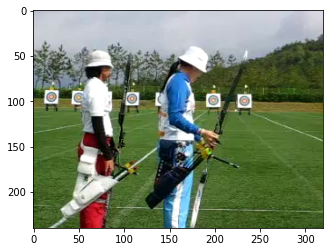

In [ ]:
plt.imshow(img)
plt.show()

Теперь нужно покадрово сохранить видео для дальнейшего анализа

In [ ]:
num = video.get_clip(0, 1)['video'].shape[1]
!mkdir /content/images
file = open("/content/images_path.txt","w")
for i in range(num):
  crop = video.get_clip(0, 1)['video'].transpose(0, 1)[i].permute(1, 2, 0).numpy() * 1
  img = Image.fromarray(crop.astype(np.uint8),'RGB')
  img.save(f"/content/images/im{i}.jpg")
  file.write(f"/content/images/im{i}.jpg\n")

file.close()

In [ ]:
# !rm -rf /content/images

Теперь можем проанализировать настроение на всем видео покадрово

In [ ]:
!python predict.py /content/images_path.txt --model vgg19_finetuned_all --batch-size 64 > /content/predictions.csv

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0% 0/1 [00:00<?, ?it/s]/content/visual-sentiment-analysis/vgg19.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax         = F.softmax(fc8_retrain_1)
100% 1/1 [00:02<00:00,  2.66s/it]


In [ ]:
df = pd.read_csv('/content/predictions.csv', header=None)
df.columns = ['negative', 'neutral', 'positive']
df

,negative,neutral,positive
0,0.301514,0.570843,0.127643
1,0.294702,0.573215,0.132083
2,0.299451,0.573427,0.127121
3,0.286550,0.585486,0.127965
4,0.283357,0.564159,0.152484
5,0.315662,0.537506,0.146833
6,0.337254,0.523999,0.138747
7,0.370169,0.508044,0.121786
8,0.396425,0.489001,0.114574
9,0.397154,0.491813,0.111033


In [ ]:
df.idxmax(axis="columns")

0     neutral
1     neutral
2     neutral
3     neutral
4     neutral
5     neutral
6     neutral
7     neutral
8     neutral
9     neutral
10    neutral
11    neutral
12    neutral
13    neutral
14    neutral
15    neutral
16    neutral
17    neutral
18    neutral
19    neutral
20    neutral
21    neutral
22    neutral
23    neutral
24    neutral
25    neutral
26    neutral
27    neutral
28    neutral
29    neutral
dtype: object

Ура, мы посмотрели на секундное видео, где неизменно нейтральное настроение, попробуем проанализировать настроение на рекламном ролике. Будем сохранять кадр в секунду


In [ ]:
video_path = "/content/video_ad1.mp4"
video = EncodedVideo.from_path(video_path)

In [ ]:
video.get_clip(0, 85)['video'].shape

torch.Size([3, 2548, 360, 640])

In [ ]:
video = video.get_clip(0, 85)['video']

num = video.shape[1]
!mkdir /content/images
file = open("/content/images_path.txt","w")
for i in range(0, num, 15):
  crop = video.transpose(0, 1)[i].permute(1, 2, 0).numpy() * 1
  img = Image.fromarray(crop.astype(np.uint8),'RGB')
  img.save(f"/content/images/im{i}.jpg")
  file.write(f"/content/images/im{i}.jpg\n")

file.close()

mkdir: cannot create directory ‘/content/images’: File exists


In [ ]:
!python predict.py /content/images_path.txt --model vgg19_finetuned_all --batch-size 64 > /content/predictions.csv

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0% 0/3 [00:00<?, ?it/s]/content/visual-sentiment-analysis/vgg19.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax         = F.softmax(fc8_retrain_1)
100% 3/3 [00:07<00:00,  2.57s/it]


In [ ]:
df = pd.read_csv('/content/predictions.csv', header=None)
df.columns = ['negative', 'neutral', 'positive']
df

,negative,neutral,positive
0,0.356822,0.523618,0.119560
1,0.663097,0.231235,0.105668
2,0.615506,0.165111,0.219383
3,0.415206,0.191006,0.393788
4,0.621807,0.258075,0.120119
...,...,...,...
165,0.555212,0.276373,0.168415
166,0.455143,0.326299,0.218558
167,0.485517,0.314103,0.200381
168,0.362786,0.365482,0.271732


Посмотрим на график настроения в видео

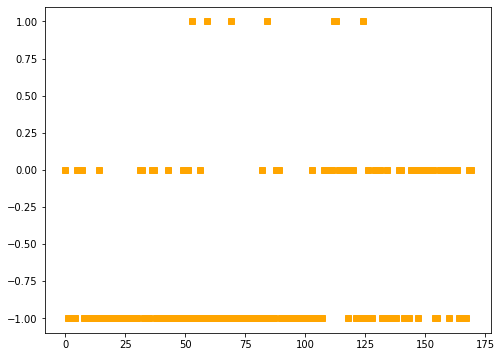

In [ ]:
df.columns = [-1, 0, 1]

df.idxmax(axis="columns").plot.line(c='orange', style='s', linewidth='3', figsize=(8,6))

Найдем что-нибудь точно позитивное и проверим, что модель хорошо умеет определять и такое настроение (потому что прошлое видео не было настолько негативнфым, каким его видит модель)

In [ ]:
# !sudo wget https://yt-dl.org/downloads/latest/youtube-dl -O /usr/local/bin/youtube-dl

# !sudo chmod a+rx /usr/local/bin/youtube-dl

In [ ]:
# !youtube-dl youtube.com/watch?v=f8OmSWxF6h8

In [ ]:
video_path = "/content/smile.mp4"
video = EncodedVideo.from_path(video_path)
video = video.get_clip(0, 55)['video']

num = video.shape[1]
!mkdir /content/images
file = open("/content/images_path.txt","w")
for i in range(0, num, 15):
  crop = video.transpose(0, 1)[i].permute(1, 2, 0).numpy() * 1
  img = Image.fromarray(crop.astype(np.uint8),'RGB')
  img.save(f"/content/images/im{i}.jpg")
  file.write(f"/content/images/im{i}.jpg\n")

file.close()

In [ ]:
!python predict.py /content/images_path.txt --model vgg19_finetuned_all --batch-size 64 > /content/predictions.csv

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0% 0/2 [00:00<?, ?it/s]/content/visual-sentiment-analysis/vgg19.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax         = F.softmax(fc8_retrain_1)
100% 2/2 [00:08<00:00,  4.30s/it]


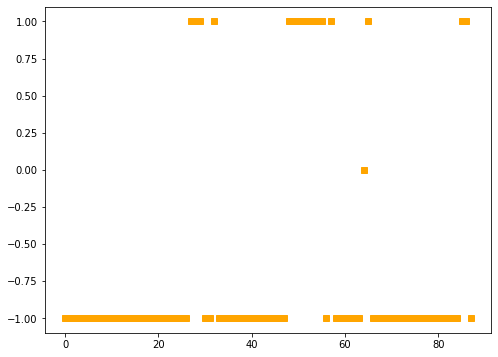

In [ ]:
df = pd.read_csv('/content/predictions.csv', header=None)
df.columns = [-1, 0, 1]
df.idxmax(axis="columns").plot.line(c='orange', style='s', linewidth='3', figsize=(8,6))

И снова мы получили очень грустное видео, хотя по факту оно состоит из смеющихся людей. Посмотрим на однозначно грустное видео

In [ ]:
video_path = "/content/crying.mp4"
video = EncodedVideo.from_path(video_path)
video = video.get_clip(0, 55)['video']

num = video.shape[1]
!mkdir /content/images
file = open("/content/images_path.txt","w")
for i in range(0, num, 15):
  crop = video.transpose(0, 1)[i].permute(1, 2, 0).numpy() * 1
  img = Image.fromarray(crop.astype(np.uint8),'RGB')
  img.save(f"/content/images/im{i}.jpg")
  file.write(f"/content/images/im{i}.jpg\n")

file.close()

In [ ]:
!python predict.py /content/images_path.txt --model vgg19_finetuned_all --batch-size 64 > /content/predictions.csv

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0% 0/2 [00:00<?, ?it/s]/content/visual-sentiment-analysis/vgg19.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax         = F.softmax(fc8_retrain_1)
100% 2/2 [00:08<00:00,  4.18s/it]


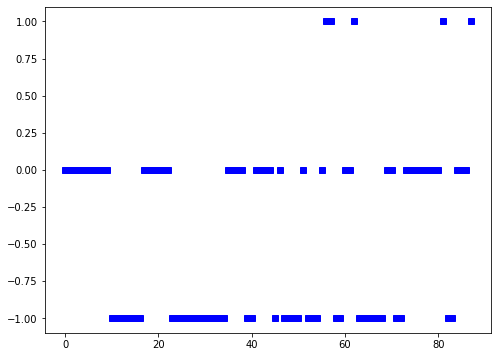

In [ ]:
df = pd.read_csv('/content/predictions.csv', header=None)
df.columns = [-1, 0, 1]
df.idxmax(axis="columns").plot.line(c='blue', style='s', linewidth='3', figsize=(8,6))

Теперь протестируем модель для выделения ключевых моментов в видео - Temporal Action Localization

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:35
🔁 Restarting kernel...


In [ ]:
!conda create -n vedatad python=3.8.5 -y
!conda activate vedatad


Solving environment: / failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done


==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 22.9.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local/envs/vedatad

  added / updated specs:
    - python=3.8.5


The following NEW packages will be INSTALLED:

  _libgcc_mutex      conda-forge/linux-64::_libgcc_mutex-0.1-conda_forge
  _openmp_mutex      conda-forge/linux-64::_openmp_mutex-4.5-2_gnu
  ca-certificates    conda-forge/linux-64::ca-certificates-2022.9.24-ha878542_0
  ld_impl_linux-64   conda-forge/linux-64::ld_impl_linux-64-2.39-hc81fddc_0
  libffi     

In [ ]:
!conda install pytorch==1.10.1 torchvision==0.11.2 torchaudio==0.10.1 cudatoolkit=11.3 -c pytorch -c conda-forge


cudatoolkit-11.3.1   | 816.4 MB  | : 100% 1.0/1 [01:35<00:00, 95.84s/it]               
torchaudio-0.10.1    | 4.5 MB    | : 100% 1.0/1 [00:02<00:00,  2.30s/it]               
xorg-libxdmcp-1.1.3  | 19 KB     | : 100% 1.0/1 [00:00<00:00, 40.05it/s]
openh264-2.1.1       | 1.5 MB    | : 100% 1.0/1 [00:00<00:00,  4.35it/s]
llvm-openmp-14.0.4   | 5.8 MB    | : 100% 1.0/1 [00:00<00:00,  1.29it/s]
gmp-6.2.1            | 806 KB    | : 100% 1.0/1 [00:00<00:00,  7.03it/s]
blas-2.116           | 13 KB     | : 100% 1.0/1 [00:00<00:00, 39.59it/s]
libgfortran-ng-12.2. | 22 KB     | : 100% 1.0/1 [00:00<00:00, 32.56it/s]
lame-3.100           | 496 KB    | : 100% 1.0/1 [00:00<00:00, 10.79it/s]
jpeg-9e              | 269 KB    | : 100% 1.0/1 [00:00<00:00, 13.94it/s]
ffmpeg-4.3           | 9.9 MB    | : 100% 1.0/1 [00:01<00:00,  1.23s/it]
libdeflate-1.14      | 81 KB     | : 100% 1.0/1 [00:00<00:00, 28.68it/s]
nettle-3.6           | 6.5 MB    | : 100% 1.0/1 [00:00<00:00,  1.19it/s]
lerc-4.0.0           

In [ ]:
!git clone https://github.com/klauscc/TALLFormer
%cd TALLFormer/vedatad
!vedatad_root=${PWD}
%cd ..

In [ ]:
!pip install -r requirements/build.txt
!pip install -v -e .

In [ ]:
!conda install -c conda-forge ffmpeg


In [ ]:
!./tools/data/extract_frames.sh /content/data data/my/frames_15fps_256x256/val -vf fps=15 -s 256x256 %05d.png

In [ ]:
!mkdir -p ./data/pretrained_models/vswin
!wget https://github.com/SwinTransformer/storage/releases/download/v1.0.4/swin_tiny_patch244_window877_kinetics400_1k.pth -P ./data/pretrained_models/vswin


In [ ]:
!python ./tools/convert_vswin_ckpt.py --src ./data/pretrained_models/vswin/swin_tiny_patch244_window877_kinetics400_1k.pth


In [ ]:
!conda install -c conda-forge scikit-learn

In [ ]:
!conda install -c conda-forge timm


In [ ]:
!python3 ./tools/data/extract_features.py --config swin_t_15fps_256x256


In [ ]:
import vedatad

Попробуем потестировать модель ActionFormer

In [ ]:
!git clone https://github.com/happyharrycn/actionformer_release.git

Cloning into 'actionformer_release'...
remote: Enumerating objects: 280, done.
remote: Total 280 (delta 0), reused 0 (delta 0), pack-reused 280
Receiving objects: 100% (280/280), 606.21 KiB | 20.21 MiB/s, done.
Resolving deltas: 100% (140/140), done.


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!mkdir "/content/actionformer_release/data"

In [ ]:
!tar -xzvf "/content/gdrive/MyDrive/thumos.tar.gz" -C "/content/actionformer_release/data"

In [ ]:
!mkdir "/content/actionformer_release/pretrained"

In [ ]:
!unzip "/content/gdrive/MyDrive/thumos_i3d_reproduce_v2.zip" -d "/content/actionformer_release/pretrained"

In [ ]:
# !cd /content/actionformer_release

In [ ]:
!python /content/actionformer_release/eval.py /content/actionformer_release/configs/thumos_i3d.yaml /content/actionformer_release/pretrained/thumos_i3d_reproduce/

Traceback (most recent call last):
  File "/content/actionformer_release/eval.py", line 16, in <module>
    from libs.datasets import make_dataset, make_data_loader
  File "/content/actionformer_release/libs/datasets/__init__.py", line 3, in <module>
    from . import epic_kitchens, thumos14, anet # other datasets go here
  File "/content/actionformer_release/libs/datasets/anet.py", line 12, in <module>
    from ..utils import remove_duplicate_annotations
  File "/content/actionformer_release/libs/utils/__init__.py", line 1, in <module>
    from .nms import batched_nms
  File "/content/actionformer_release/libs/utils/nms.py", line 5, in <module>
    import nms_1d_cpu
ModuleNotFoundError: No module named 'nms_1d_cpu'
